In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib import font_manager, rc, cm                
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import folium
import json
from folium import plugins
print(folium.__version__)

font_path = './font/GmarketSansTTFMedium.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)


0.12.1.post1


In [17]:
# 데이터 불러오기

df = pd.read_excel('./data/통합파일_진짜_강서구제외.xlsx', index_col=1)
df.drop(['지 역','전세가율'], axis=1, inplace=True)
df

,사고건수(건),다세대주택,아파트,다가구주택,단독주택,연립주택
SIG_KOR_NM,,,,,,
고양시덕양구,15,1756,5016,97,253,294
고양시일산동구,14,781,2527,59,193,255
과천시,4,104,286,21,22,7
광명시,4,1368,2681,56,102,106
광주시,8,4967,3165,102,794,324
...,...,...,...,...,...,...
미추홀구,75,6660,4938,106,830,727
부평구,87,5497,7407,124,281,459
서구,73,5769,8489,169,235,913


In [18]:
df.corr()


,사고건수(건),다세대주택,아파트,다가구주택,단독주택,연립주택
사고건수(건),1.000000,0.729508,0.241879,0.172218,0.149757,0.567184
다세대주택,0.729508,1.000000,0.208406,0.271267,0.160326,0.604776
아파트,0.241879,0.208406,1.000000,-0.074912,0.184086,0.409025
다가구주택,0.172218,0.271267,-0.074912,1.000000,0.095987,0.099436
단독주택,0.149757,0.160326,0.184086,0.095987,1.000000,0.398900
연립주택,0.567184,0.604776,0.409025,0.099436,0.398900,1.000000


C:\Users\User\anaconda3\envs\pydatavenv\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\envs\pydatavenv\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


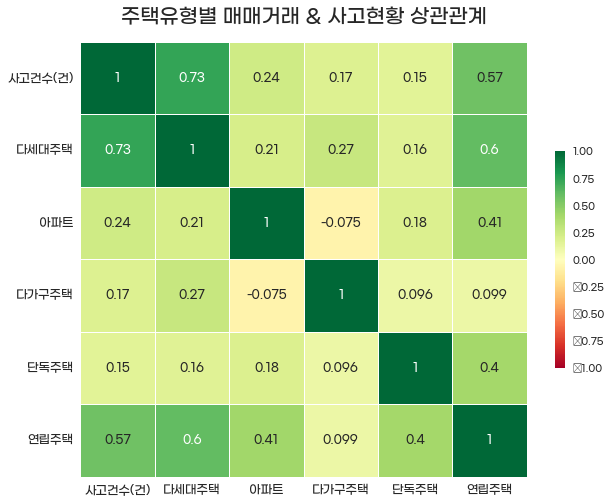

In [31]:
fig, ax = plt.subplots( figsize=(10,8) )

# 히트맵을 그린다
sns.heatmap(df.corr(), 
            cmap = 'RdYlGn',
            annot = True,
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.title('주택유형별 매매거래 & 사고현황 상관관계', fontsize=20, pad=20)
plt.yticks(size=12,rotation=0)
plt.xticks(size=12)
plt.savefig('output/주택유형별 매매거래와 사고현황 상관관계.png')

In [121]:
# Min-Max 정규화

data = df[['호당 매매가(천원)', '호당 전세가(천원)','전세가율(%)']]

scaler = MinMaxScaler()
data_scale = scaler.fit_transform(data)

# ndata = pd.DataFrame(data_scale)
# ndata.index=data.index
# ndata.columns=data.bin

C:\Users\User\anaconda3\envs\pydatavenv\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


AttributeError: 'KMeans' object has no attribute 'k'

AttributeError: 'KMeans' object has no attribute 'k'

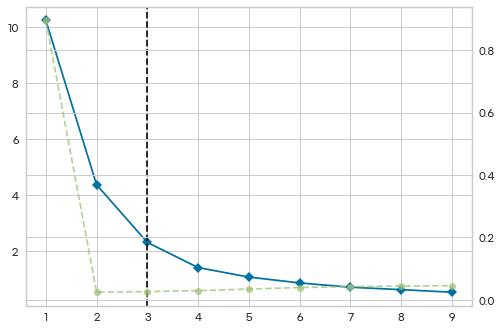

In [122]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data_scale)

In [124]:
k = 3

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(data_scale)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
df['cluster'] = model.fit_predict(data_scale)
print(df.head())

            호당 매매가(천원)  호당 전세가(천원)    전세가율(%)  건축허가면적(m2)  지하철역 수(개)  \
SIG_KOR_NM                                                             
고양시덕양구           53277       35920  67.421214     2056575         10   
고양시일산동구          58203       41642  71.546140     1381215          6   
고양시일산서구          46728       33288  71.237802      475295          4   
과천시             171050       68439  40.011108      745226          5   
광명시              70631       35839  50.741176      167622          3   

            주민등록세대수(호)  은행 점포수(개)  1인가구(세대)  아파트 매매거래 수  아파트 입주예정 물량(세대)  \
SIG_KOR_NM                                                                 
고양시덕양구          210486         26     76849       12176            30933   
고양시일산동구         128436         39     47490        5016            10929   
고양시일산서구         117930         26     34523        2527             3248   
과천시              27262         12      6635        4633            12784   
광명시             119817         26     3

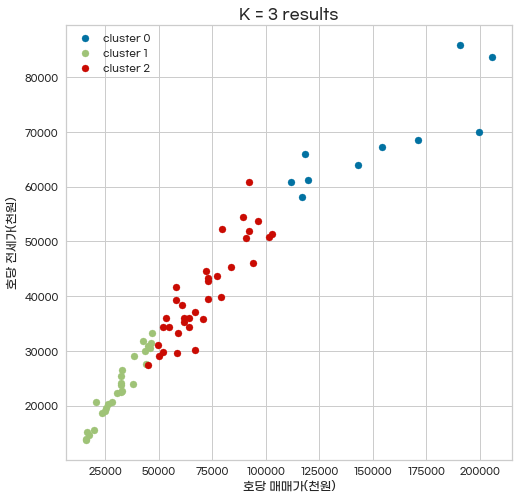

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df.loc[df['cluster'] == i, '호당 매매가(천원)'], df.loc[df['cluster'] == i, '호당 전세가(천원)'], 
                label = 'cluster ' + str(i))
    
plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('호당 매매가(천원)', size = 12)
plt.ylabel('호당 전세가(천원)', size = 12)
plt.show()

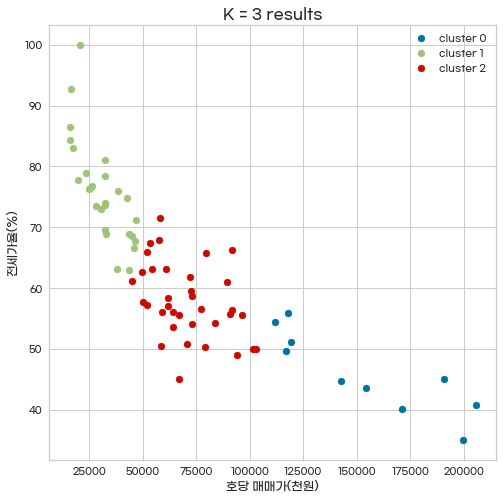

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df.loc[df['cluster'] == i, '호당 매매가(천원)'], df.loc[df['cluster'] == i, '전세가율(%)'], 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('호당 매매가(천원)', size = 12)
plt.ylabel('전세가율(%)', size = 12)
plt.show()

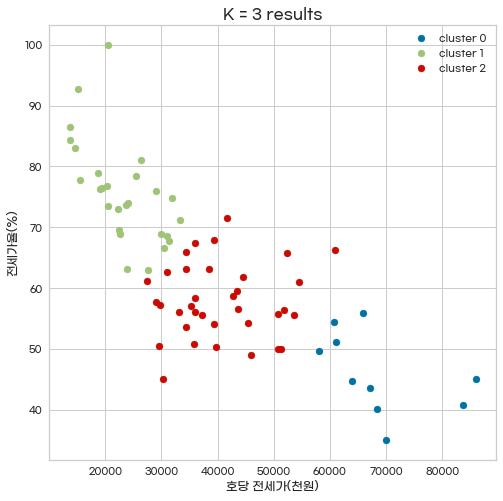

In [127]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(df.loc[df['cluster'] == i, '호당 전세가(천원)'], df.loc[df['cluster'] == i, '전세가율(%)'], 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('호당 전세가(천원)', size = 12)
plt.ylabel('전세가율(%)', size = 12)
plt.show()

In [82]:
clu1 = df[(df['cluster'] == 0)]
clu2 = df[(df['cluster'] == 1)]
clu3 = df[(df['cluster'] == 2)]

In [128]:
# 군집분석 지도 시각화

state_geo = 'data/전국_군집분석용.json'
state_geo2 = json.load(open(state_geo, encoding ="utf-8"))

In [129]:
m = folium.Map(location = [37.5760, 126.9769], tiles="OpenStreetMap", zoom_start=9)

choropleth = folium.Choropleth(
    geo_data=state_geo2,
    name = "지도",
    data = df,
    columns=(df.index, "cluster"),
    fill_color='Spectral',
    key_on="feature.properties.SIG_KOR_NM",
    fill_opactiy = 1,
    line_opacity = 0.5,
    nan_fill_color='#FAEB78',
    nan_fill_opacity=0,
).add_to(m)

In [130]:
m

m.save('군집분석_시각화.html')

In [131]:
df.to_csv('./data/통합파일_군집.csv')